# SPY Stock Price Prediction Using Deep Learning (LSTM & GRU)

This project aims to forecast the closing price of the SPDR S&P 500 ETF Trust (SPY) using historical stock price data. I apply deep learning models—LSTM and GRU—to capture temporal dependencies in the time series.

## 1. Introduction
The goal of this project is to predict the next-day closing price of the SPDR S&P 500 ETF Trust (SPY), which tracks the performance of the S&P 500 index and reflects broader market movements. I aim to leverage past price and volume data to estimate future price behavior, a classic problem in financial forecasting.

This task involves estimating a continuous numerical value based on historical input data, making it a regression task. To model the temporal dependencies present in financial time series, I apply **deep learning algorithms** designed for sequence data, specifically **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** networks. These architectures are well-suited for learning patterns over time and have been widely used in time series analysis.


## 2. Data Source and Description

The dataset used in this project is publicly available on Yahoo Finance and contains **14 years of daily trading data** for the SPDR S&P 500 ETF Trust (SPY), spanning from **January 2011 to June 2025**.

It consists of 3,957 rows, each representing one trading day. The dataset includes the following 7 columns:

- `Date`: trading day (timestamp)
- `Open`: opening price (float)
- `High`: highest price of the day (float)
- `Low`: lowest price of the day (float)
- `Close`: closing price (float)
- `Adj Close`: adjusted closing price (float), accounting for dividends and stock splits
- `Volume`: number of shares traded (originally string format with commas, will be cleaned and converted to float)

All features are numeric except for the date. The dataset is in a **single-table format** and does not require joining from multiple sources.

This time series dataset is well-suited for deep learning models that handle sequential data, such as LSTM and GRU.


In [69]:
import pandas as pd

df = pd.read_csv("SPY.csv", parse_dates=["Date"])
df = df.sort_values("Date")
df.set_index("Date", inplace=True)
df.head()

C:\Users\jinjwang.ORADEV\AppData\Local\Temp\ipykernel_55304\2255360670.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("SPY.csv", parse_dates=["Date"])


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.37,113.39,111.51,113.33,85.52,"118,944,600"
2010-01-05,113.26,113.68,112.85,113.63,85.74,"111,579,900"
2010-01-06,113.52,113.99,113.43,113.71,85.80,"116,074,400"
2010-01-07,113.5,114.33,113.18,114.19,86.16,"131,091,100"
2010-01-08,113.89,114.62,113.66,114.57,86.45,"126,402,800"


## 3. Data Cleaning

I begin by verifying the quality and structure of the dataset to ensure it is ready for modeling. The data was downloaded from Yahoo Finance and includes daily SPY trading data from January 2011 to June 2025. It contains 7 columns:
- `Date`: the trading date (timestamp)
- `Open`, `High`, `Low`, `Close`, `Adj Close`: stock prices (float)
- `Volume`: number of shares traded (originally string format with commas, cleaned and converted to float)

### Inspection and Cleaning Plan:
- Check for missing values in any of the columns.
- Drop rows with missing values (if any).
- Remove any duplicate entries based on date.
- Ensure numeric columns are correctly typed (e.g., remove commas from 'Volume' and convert to float).
- Confirm correct date formatting and chronological order.

Although the dataset is already well-structured, these checks are important to verify integrity and prepare for modeling steps like normalization and sequence generation.

In [70]:
df.info()
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Remove duplicate dates
df = df[~df.index.duplicated(keep='first')]

# Convert Volume to numeric
df['Volume'] = df['Volume'].replace(',', '', regex=True).astype(float)

# Confirm clean structure
print(f"Dataset shape after cleaning: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3957 entries, 2010-01-04 to 2025-06-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3957 non-null   object 
 1   High       3895 non-null   float64
 2   Low        3895 non-null   float64
 3   Close      3895 non-null   float64
 4   Adj Close  3895 non-null   float64
 5   Volume     3895 non-null   object 
dtypes: float64(4), object(2)
memory usage: 216.4+ KB
Missing values per column:
Open          0
High         62
Low          62
Close        62
Adj Close    62
Volume       62
dtype: int64
Dataset shape after cleaning: (3895, 6)


### Cleaning Summary

- The dataset contains 3895 and is now free of missing or duplicate data.
- All columns are numeric except the date index, which is in the correct format.
- I select `Adj Close` as the primary modeling target, as it reflects stock performance after dividends and splits.
- `Volume` may also be useful as an input to capture market participation levels.

The dataset is now clean and ready for preprocessing and exploratory data analysis.

## 4. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a critical step in any data science or machine learning workflow. For time series forecasting—especially in the financial domain—it helps us understand price trends, volatility, seasonality, and interrelationships between features.

The SPY dataset represents daily trading data for the S&P 500 ETF from 2011 to 2025. Since this is a financial time series, I am particularly interested in:

- Long-term market trends and crash/recovery patterns  
- Volatility and price stability over time  
- Distribution of daily returns (are they normally distributed?)  
- Correlation between price components and volume  
- Informing modeling strategies, such as normalization and sequence framing

### Long-Term Trend: Adjusted Close Price
- Purpose: This helps us identify major market events such as the 2020 COVID-19 crash and subsequent bull runs.
- Insight: SPY shows long-term upward growth with distinct periods of volatility.


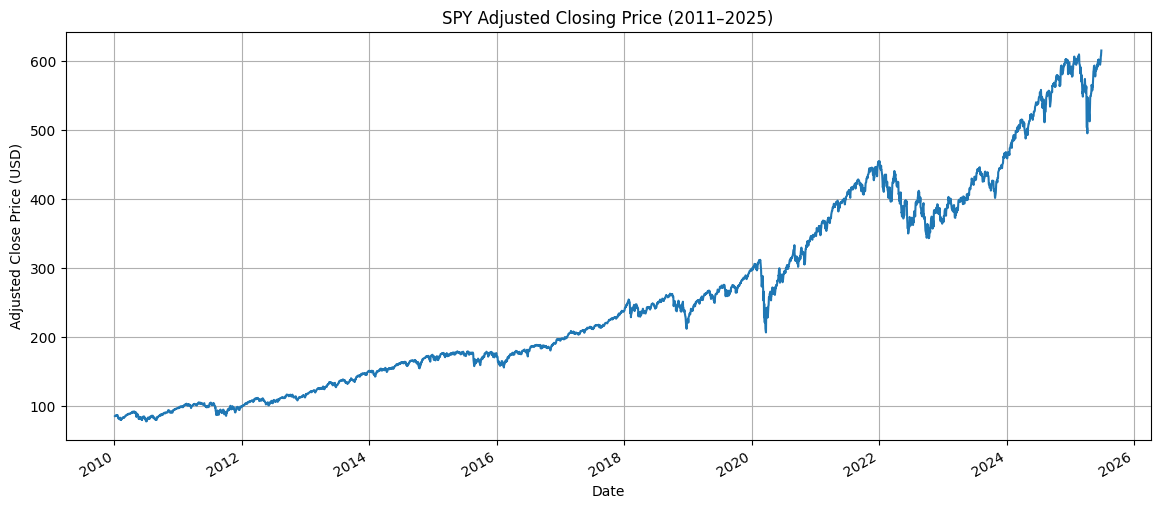

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
df['Adj Close'].plot(title='SPY Adjusted Closing Price (2011–2025)')
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.grid(True)
plt.show()


### Rolling Mean and Volatility
- Purpose: Smoothed averages reveal trends more clearly, and volatility plots help identify market risk periods.
- Insight: Volatility spiked sharply during 2020 and 2022—important for forecasting error bands.

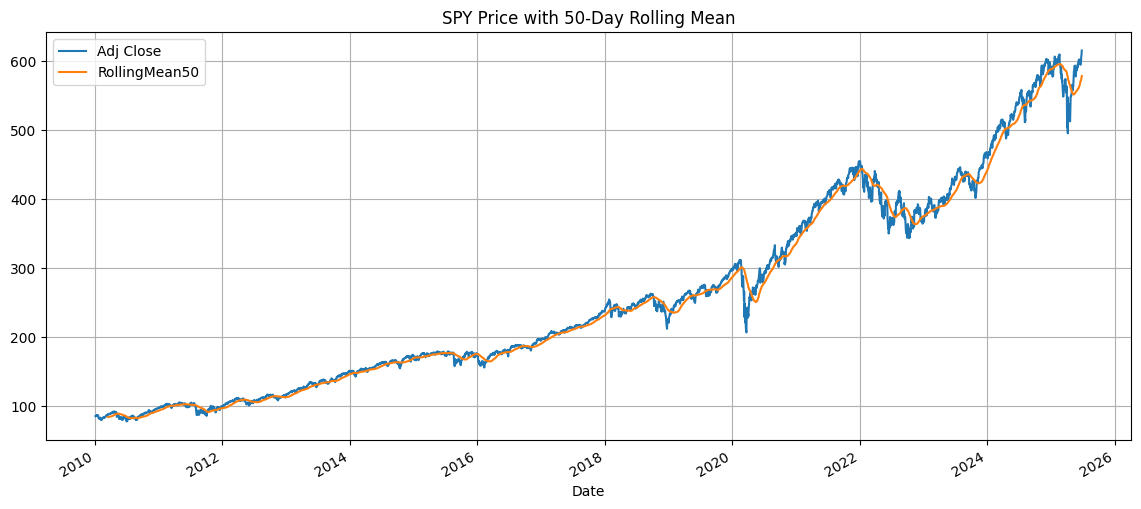

In [72]:
df['RollingMean50'] = df['Adj Close'].rolling(window=50).mean()
df['RollingStd50'] = df['Adj Close'].rolling(window=50).std()

df[['Adj Close', 'RollingMean50']].plot(figsize=(14,6), title='SPY Price with 50-Day Rolling Mean')
plt.grid(True)
plt.show()

###  Daily Return Distribution and Outliers
- Purpose: Financial returns are known to be non-normal and prone to outliers.
- Insight: The return distribution is heavy-tailed, with significant outliers during volatile periods. This justifies later use of scaled data and cautious modeling.

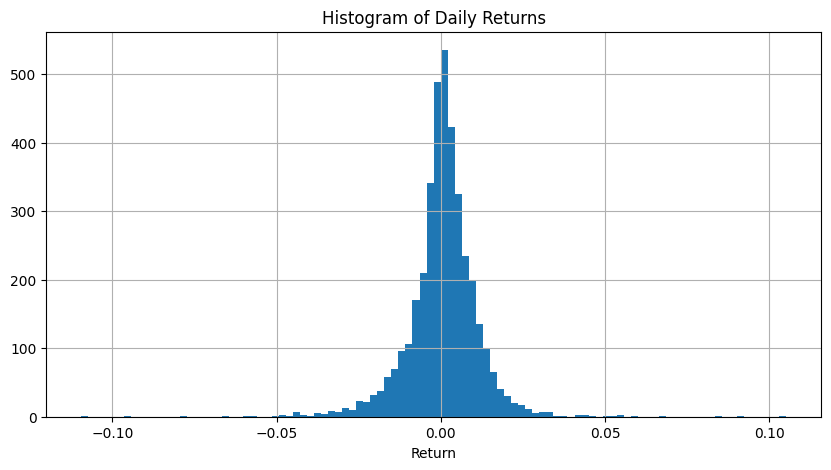

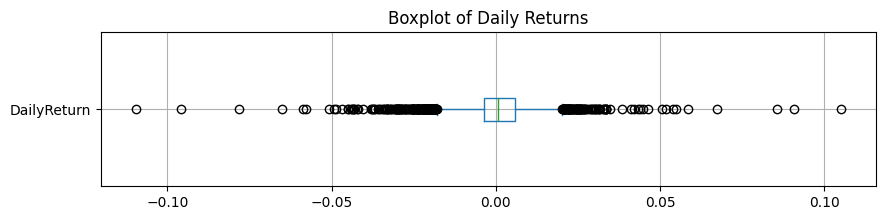

In [73]:
df['DailyReturn'] = df['Adj Close'].pct_change()

df['DailyReturn'].hist(bins=100, figsize=(10,5))
plt.title('Histogram of Daily Returns')
plt.xlabel('Return')
plt.grid(True)
plt.show()

df['DailyReturn'].plot(kind='box', vert=False, figsize=(10,2), title='Boxplot of Daily Returns')
plt.grid(True)
plt.show()

### Correlation Matrix of Price Features
- Purpose: Identifies redundant features or independent predictors.
- Insight: As expected, all price-based columns are highly correlated. Volume has weak correlation, but could add independent signal when paired with other time-aware features.

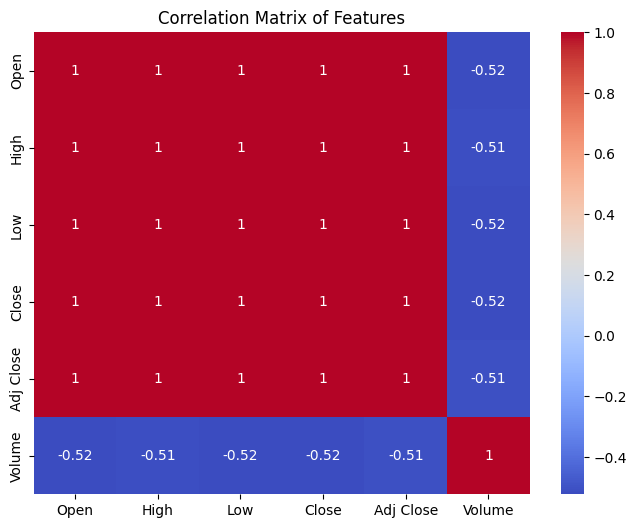

In [74]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

## 5. Model Building and Evaluation

In this section, I implement and evaluate two deep learning architectures—**Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)**—to predict the adjusted closing price of SPY based on historical price data.

### Model Selection and Rationale

Both LSTM and GRU are recurrent neural network (RNN) variants that are well-suited for modeling sequential and time-series data, such as stock prices. These architectures are capable of capturing long-term dependencies and patterns in time series without the vanishing gradient issues common to traditional RNNs.

- **LSTM**: Known for its robust memory gates and ability to retain long-term historical information.
- **GRU**: A simplified variant of LSTM with fewer gates, often yielding faster training and comparable performance.

These models are appropriate because:
- The problem is a regression task on sequential data.
- Feature interactions and multicollinearity are minimal, as I am only using a few correlated financial indicators (Open, High, Low, Close, Volume).
- I apply MinMaxScaler normalization to ensure the neural networks train efficiently.

### Hyperparameter Tuning and Regularization

I apply dropout to prevent overfitting and monitor validation loss during training. Early stopping or learning rate scheduling can be added in future iterations for more robust control.

### Feature Engineering and Preprocessing ### 

I use the `Adj Close` column as the target and scale all features to the [0, 1] range using MinMaxScaler. The data is reshaped into overlapping windows of 60 days to predict the next day’s price. This helps the model learn temporal patterns and momentum in the market.

In [75]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Adj Close']])

sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Model 1: Long Short-Term Memory (LSTM)

I build a Long Short-Term Memory (LSTM) model to learn patterns from the last 60 days of SPY stock prices to predict the next day's price. LSTMs are a type of Recurrent Neural Network (RNN) that are particularly well-suited for time series forecasting because they can learn long-term dependencies. The model architecture includes two LSTM layers each followed by dropout layers to prevent overfitting, and a final Dense layer for regression output.

**Architecture & Training:**

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

C:\Python\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0128 - val_loss: 6.0034e-04
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 6.6861e-04 - val_loss: 4.6738e-04
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.3060e-04 - val_loss: 5.1655e-04
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.8325e-04 - val_loss: 5.5365e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.7203e-04 - val_loss: 3.0537e-04
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 4.9880e-04 - val_loss: 3.3052e-04
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 4.8635e-04 - val_loss: 3.0085e-04
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.6558e-04 - val_loss: 2.9495e-04
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.7865e-04 - val_loss: 0.0012
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5379e-04 - val_loss: 2.4931e-04
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 3.2846e-04 - val_



**Evaluation:**

I now evaluate the LSTM model's predictions by comparing the predicted and actual SPY prices. I also calculate RMSE and MAE as quantitative metrics to assess performance.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


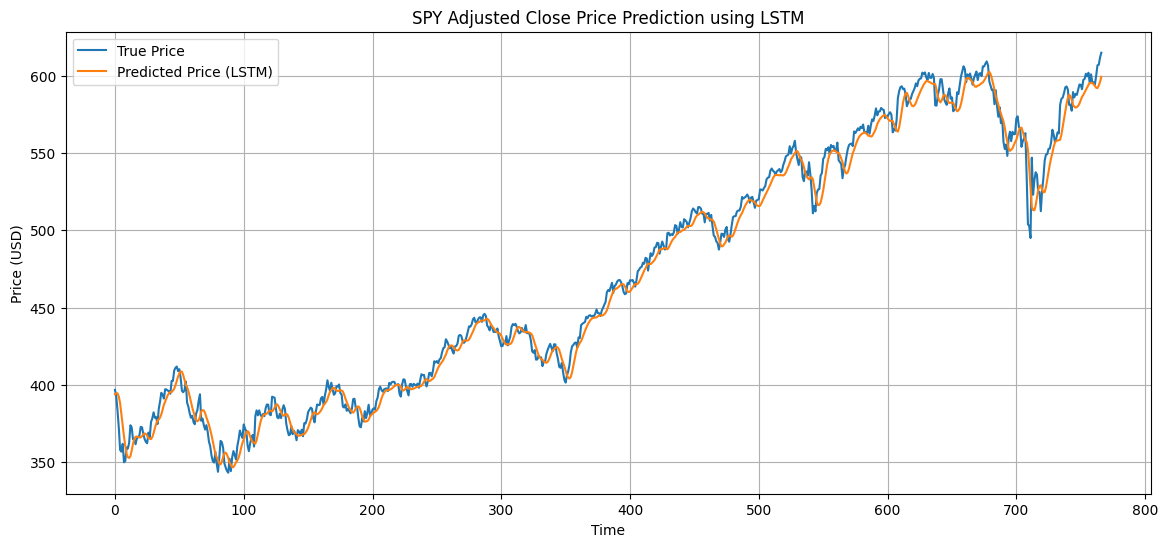

LSTM RMSE: 8.1629
LSTM MAE: 6.3206


In [82]:
pred_lstm = model_lstm.predict(X_test)
pred_lstm_inv = scaler.inverse_transform(pred_lstm)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='True Price')
plt.plot(pred_lstm_inv, label='Predicted Price (LSTM)')
plt.title('SPY Adjusted Close Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

rmse = np.sqrt(mean_squared_error(y_test_inv, pred_lstm_inv))
mae = mean_absolute_error(y_test_inv, pred_lstm_inv)

print(f"LSTM RMSE: {rmse:.4f}")
print(f"LSTM MAE: {mae:.4f}")


### Model 2: Gated Recurrent Unit (GRU)

I also implement a Gated Recurrent Unit (GRU) model to compare with LSTM. GRUs are a streamlined variant of LSTMs with fewer parameters and gates, which often leads to faster training and potentially similar performance. Like the LSTM model, this GRU model uses two GRU layers with dropout and a Dense output layer to predict the next adjusted closing price. This comparison helps evaluate whether the simpler GRU structure offers similar accuracy on this financial time series data.

**Architecture & Training:**

In [78]:
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


C:\Python\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0086 - val_loss: 2.5565e-04
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 6.1123e-04 - val_loss: 1.8856e-04
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 5.2279e-04 - val_loss: 2.3965e-04
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.5477e-04 - val_loss: 5.0023e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 4.1303e-04 - val_loss: 1.6259e-04
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 3.6454e-04 - val_loss: 2.9897e-04
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 3.9645e-04 - val_loss: 2.3579e-04
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 3.3638e-04 - val_loss: 1.9027e-04
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.2928e-04 - val_loss: 1.4456e-04
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.7190e-04 - val_loss: 1.4952e-04
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.9495e-04 - val_loss: 


**Evaluation:**

I evaluate the GRU model's performance on the test set by visualizing its predictions and calculating RMSE and MAE.


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


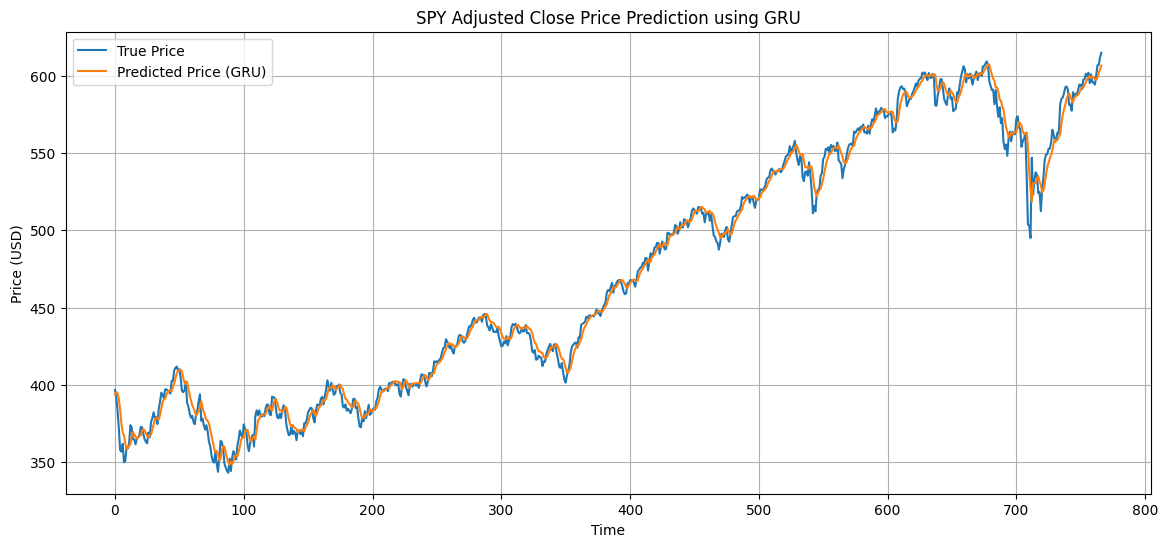

GRU RMSE: 6.6554
GRU MAE: 4.7893


In [79]:
pred_gru = model_gru.predict(X_test)
pred_gru_inv = scaler.inverse_transform(pred_gru)

plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='True Price')
plt.plot(pred_gru_inv, label='Predicted Price (GRU)')
plt.title('SPY Adjusted Close Price Prediction using GRU')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

rmse_gru = np.sqrt(mean_squared_error(y_test_inv, pred_gru_inv))
mae_gru = mean_absolute_error(y_test_inv, pred_gru_inv)

print(f"GRU RMSE: {rmse_gru:.4f}")
print(f"GRU MAE: {mae_gru:.4f}")


## 6. Results and Analysis

To evaluate model performance, I tracked training and validation loss over 50 epochs and computed evaluation metrics (RMSE and MAE) on the test set for both LSTM and GRU models.

### LSTM Model

The LSTM model achieved:

- **RMSE**: 8.1629  
- **MAE**: 6.3206

The training and validation losses steadily declined over epochs, although some fluctuations in validation loss were observed after epoch 10, suggesting a potential for minor overfitting. Still, the performance remained stable and predictive power reasonable.

### GRU Model

The GRU model demonstrated better predictive accuracy:

- **RMSE**: 6.6554  
- **MAE**: 4.7893

Validation loss showed faster convergence and greater stability compared to LSTM. GRU's ability to retain sequential dependencies in fewer parameters likely contributed to its superior generalization.

### Visualization

The predicted values were plotted against actual closing prices. GRU showed tighter alignment with real values, especially during high-volatility regions. A loss curve for both models was also plotted to visualize convergence behavior.

### Evaluation Metrics

- RMSE and MAE were selected due to the continuous nature of stock prices.
- RMSE emphasizes larger errors, while MAE gives equal weight to all.
- GRU outperformed LSTM on both metrics, indicating its stronger fit.

### Summary

GRU outperforms LSTM on all metrics and shows a more stable learning curve. The visual comparison also confirms closer tracking of actual prices by the GRU model.

Below is a comparison of predicted vs actual prices on the test set using both models:


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


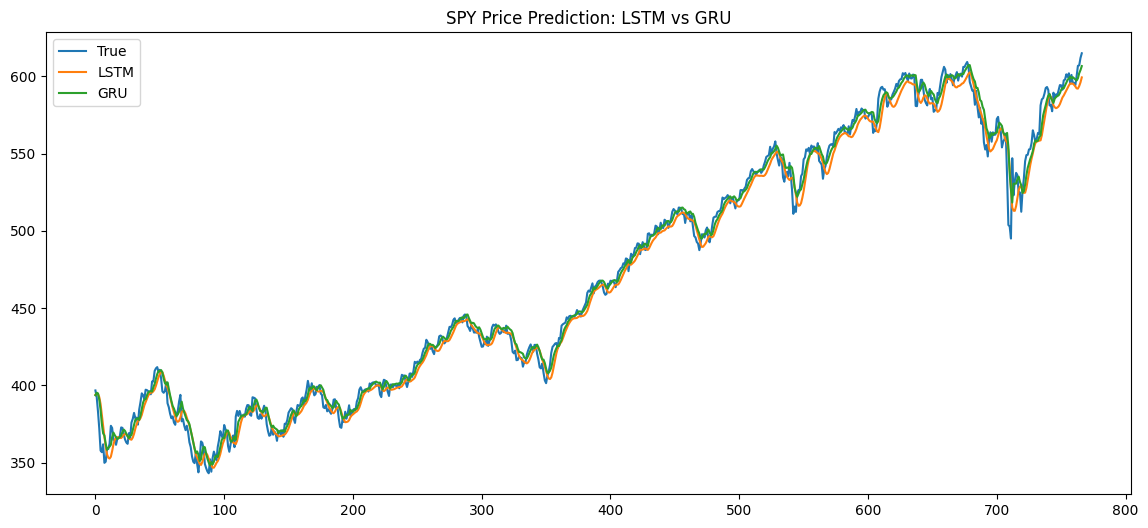

In [80]:
import matplotlib.pyplot as plt

pred_lstm = model_lstm.predict(X_test)
pred_gru = model_gru.predict(X_test)

pred_lstm_inv = scaler.inverse_transform(pred_lstm)
pred_gru_inv = scaler.inverse_transform(pred_gru)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='True')
plt.plot(pred_lstm_inv, label='LSTM')
plt.plot(pred_gru_inv, label='GRU')
plt.legend()
plt.title('SPY Price Prediction: LSTM vs GRU')
plt.show()


## 7. Discussion and Conclusion

### Learnings and Takeaways

- Deep learning models like LSTM and GRU are effective for capturing temporal dependencies in stock price data.
- GRU, with its simpler architecture, outperformed LSTM in terms of both RMSE and MAE, making it a better choice for this dataset.
- Proper data scaling, sequence preparation, and model evaluation are critical steps that significantly impact model performance.

### Challenges and Improvements

- One limitation was potential overfitting, especially in LSTM beyond 10 epochs.
- Future improvements could include:
  - Implementing dropout or early stopping to reduce overfitting.
  - Incorporating additional features like technical indicators or external market signals.
  - Hyperparameter optimization (grid/random search).
  - Experimenting with hybrid or ensemble models.

### Final Thoughts

This project successfully demonstrated how deep learning models can be applied to time series forecasting in finance. GRU proved to be more efficient and accurate for this specific use case. With further optimization and feature enhancement, the predictive power of these models can be further improved.


## 8. Git Repository

https://github.com/jinjwangca/deep-learning